**Trace-Log Combined Microservice Anomaly
Detection through Graph-based Deep Learning :** 
A deep learning based microservice anomaly detection approach ,uses
a unified graph representation to describe the complex structure of
a trace together with log events embedded in the structure.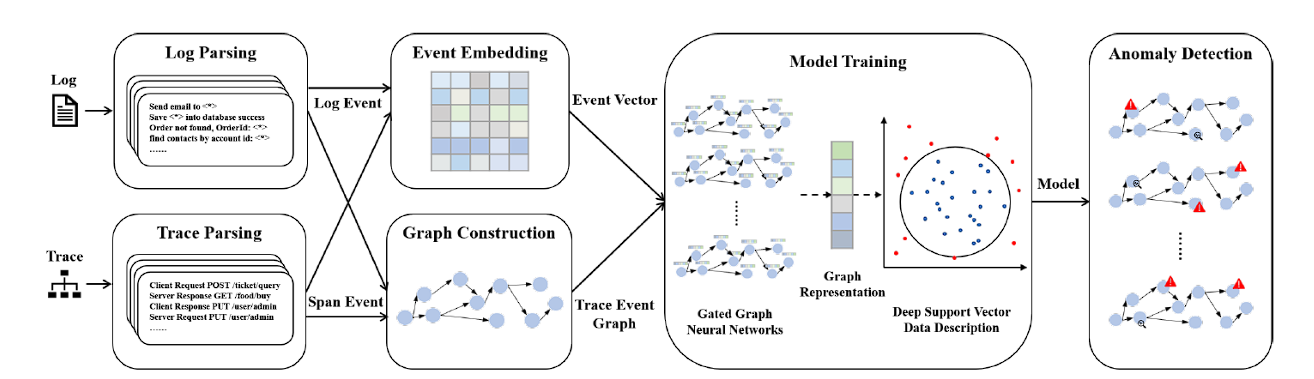
research paper : https://cspengxin.github.io/publications/icse22-DeepTraLog.pdf

Avaible data : https://github.com/FudanSELab/DeepTraLog

# Log parsing

we employ the Drain parser—a state-of-the-art method known for its real-time, accurate, and efficient log parsing.

🔹 To enable combined analysis with trace data, we extract and associate the Trace ID and Span ID with each log entry prior to parsing. These identifiers are then preserved throughout the parsing process, ensuring each parsed log event remains traceable for further correlation and graph-based analysis.

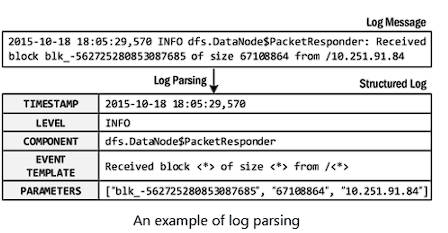

In [1]:
import regex as re
import os
import numpy as np
import pandas as pd
import hashlib
from datetime import datetime


class Logcluster:
    def __init__(self, logTemplate='', logIDL=None):
        self.logTemplate = logTemplate
        if logIDL is None:
            logIDL = []
        self.logIDL = logIDL


class Node:
    def __init__(self, childD=None, depth=0, digitOrtoken=None):
        if childD is None:
            childD = dict()
        self.childD = childD
        self.depth = depth
        self.digitOrtoken = digitOrtoken


class LogParser:
    def __init__(self, log_format, indir='./', outdir='./result/', depth=4, st=0.4, 
                 maxChild=100, rex=[], keep_para=True):
        """
        Attributes
        ----------
            rex : regular expressions used in preprocessing (step1)
            path : the input path stores the input log file name
            depth : depth of all leaf nodes
            st : similarity threshold
            maxChild : max number of children of an internal node
            logName : the name of the input file containing raw log messages
            savePath : the output path stores the file containing structured logs
        """
        self.path = indir
        self.depth = depth - 2
        self.st = st
        self.maxChild = maxChild
        self.logName = None
        self.savePath = outdir
        self.df_log = None
        self.log_format = log_format
        self.rex = rex
        self.keep_para = keep_para

    def hasNumbers(self, s):
        return any(char.isdigit() for char in s)

    def treeSearch(self, rn, seq):
        retLogClust = None

        seqLen = len(seq)
        if seqLen not in rn.childD:
            return retLogClust

        parentn = rn.childD[seqLen]

        currentDepth = 1
        for token in seq:
            if currentDepth >= self.depth or currentDepth > seqLen:
                break

            if token in parentn.childD:
                parentn = parentn.childD[token]
            elif '<*>' in parentn.childD:
                parentn = parentn.childD['<*>']
            else:
                return retLogClust
            currentDepth += 1

        logClustL = parentn.childD

        retLogClust = self.fastMatch(logClustL, seq)

        return retLogClust

    def addSeqToPrefixTree(self, rn, logClust):
        seqLen = len(logClust.logTemplate)
        if seqLen not in rn.childD:
            firtLayerNode = Node(depth=1, digitOrtoken=seqLen)
            rn.childD[seqLen] = firtLayerNode
        else:
            firtLayerNode = rn.childD[seqLen]

        parentn = firtLayerNode

        currentDepth = 1
        for token in logClust.logTemplate:

            #Add current log cluster to the leaf node
            if currentDepth >= self.depth or currentDepth > seqLen:
                if len(parentn.childD) == 0:
                    parentn.childD = [logClust]
                else:
                    parentn.childD.append(logClust)
                break

            #If token not matched in this layer of existing tree. 
            if token not in parentn.childD:
                if not self.hasNumbers(token):
                    if '<*>' in parentn.childD:
                        if len(parentn.childD) < self.maxChild:
                            newNode = Node(depth=currentDepth + 1, digitOrtoken=token)
                            parentn.childD[token] = newNode
                            parentn = newNode
                        else:
                            parentn = parentn.childD['<*>']
                    else:
                        if len(parentn.childD)+1 < self.maxChild:
                            newNode = Node(depth=currentDepth+1, digitOrtoken=token)
                            parentn.childD[token] = newNode
                            parentn = newNode
                        elif len(parentn.childD)+1 == self.maxChild:
                            newNode = Node(depth=currentDepth+1, digitOrtoken='<*>')
                            parentn.childD['<*>'] = newNode
                            parentn = newNode
                        else:
                            parentn = parentn.childD['<*>']
            
                else:
                    if '<*>' not in parentn.childD:
                        newNode = Node(depth=currentDepth+1, digitOrtoken='<*>')
                        parentn.childD['<*>'] = newNode
                        parentn = newNode
                    else:
                        parentn = parentn.childD['<*>']

            #If the token is matched
            else:
                parentn = parentn.childD[token]

            currentDepth += 1

    #seq1 is template
    def seqDist(self, seq1, seq2):
        assert len(seq1) == len(seq2)
        simTokens = 0
        numOfPar = 0

        for token1, token2 in zip(seq1, seq2):
            if token1 == '<*>':
                numOfPar += 1
                continue
            if token1 == token2:
                simTokens += 1 

        retVal = float(simTokens) / len(seq1)

        return retVal, numOfPar


    def fastMatch(self, logClustL, seq):
        retLogClust = None

        maxSim = -1
        maxNumOfPara = -1
        maxClust = None

        for logClust in logClustL:
            curSim, curNumOfPara = self.seqDist(logClust.logTemplate, seq)
            if curSim>maxSim or (curSim==maxSim and curNumOfPara>maxNumOfPara):
                maxSim = curSim
                maxNumOfPara = curNumOfPara
                maxClust = logClust

        if maxSim >= self.st:
            retLogClust = maxClust  

        return retLogClust

    def getTemplate(self, seq1, seq2):
        assert len(seq1) == len(seq2)
        retVal = []

        i = 0
        for word in seq1:
            if word == seq2[i]:
                retVal.append(word)
            else:
                retVal.append('<*>')

            i += 1

        return retVal

    def outputResult(self, logClustL):
        log_templates = [0] * self.df_log.shape[0]
        log_templateids = [0] * self.df_log.shape[0]
        df_events = []
        for logClust in logClustL:
            template_str = ' '.join(logClust.logTemplate)
            occurrence = len(logClust.logIDL)
            template_id = hashlib.md5(template_str.encode('utf-8')).hexdigest()[0:8]
            for logID in logClust.logIDL:
                logID -= 1
                log_templates[logID] = template_str
                log_templateids[logID] = template_id
            df_events.append([template_id, template_str, occurrence])

        df_event = pd.DataFrame(df_events, columns=['EventId', 'EventTemplate', 'Occurrences'])
        self.df_log['EventId'] = log_templateids
        self.df_log['EventTemplate'] = log_templates

        if self.keep_para:
            self.df_log["ParameterList"] = self.df_log.apply(self.get_parameter_list, axis=1) 
        self.df_log.to_csv(os.path.join(self.savePath, self.logName + '_structured.csv'), index=False)


        occ_dict = dict(self.df_log['EventTemplate'].value_counts())
        df_event = pd.DataFrame()
        df_event['EventTemplate'] = self.df_log['EventTemplate'].unique()
        df_event['EventId'] = df_event['EventTemplate'].map(lambda x: hashlib.md5(x.encode('utf-8')).hexdigest()[0:8])
        df_event['Occurrences'] = df_event['EventTemplate'].map(occ_dict)
        df_event.to_csv(os.path.join(self.savePath, self.logName + '_templates.csv'), index=False, columns=["EventId", "EventTemplate", "Occurrences"])


    def printTree(self, node, dep):
        pStr = ''   
        for i in range(dep):
            pStr += '\t'

        if node.depth == 0:
            pStr += 'Root'
        elif node.depth == 1:
            pStr += '<' + str(node.digitOrtoken) + '>'
        else:
            pStr += node.digitOrtoken

        print(pStr)

        if node.depth == self.depth:
            return 1
        for child in node.childD:
            self.printTree(node.childD[child], dep+1)


    def parse(self, logName):
        print('Parsing file: ' + os.path.join(self.path, logName))
        start_time = datetime.now()
        self.logName = logName
        rootNode = Node()
        logCluL = []

        self.load_data()

        count = 0
        for idx, line in self.df_log.iterrows():
            logID = line['LineId']
            logmessageL = self.preprocess(line['Content']).strip().split()
            # logmessageL = filter(lambda x: x != '', re.split('[\s=:,]', self.preprocess(line['Content'])))
            matchCluster = self.treeSearch(rootNode, logmessageL)

            #Match no existing log cluster
            if matchCluster is None:
                newCluster = Logcluster(logTemplate=logmessageL, logIDL=[logID])
                logCluL.append(newCluster)
                self.addSeqToPrefixTree(rootNode, newCluster)

            #Add the new log message to the existing cluster
            else:
                newTemplate = self.getTemplate(logmessageL, matchCluster.logTemplate)
                matchCluster.logIDL.append(logID)
                if ' '.join(newTemplate) != ' '.join(matchCluster.logTemplate): 
                    matchCluster.logTemplate = newTemplate

            count += 1
            if count % 1000 == 0 or count == len(self.df_log):
                print('Processed {0:.1f}% of log lines.'.format(count * 100.0 / len(self.df_log)))


        if not os.path.exists(self.savePath):
            os.makedirs(self.savePath)

        self.outputResult(logCluL)

        print('Parsing done. [Time taken: {!s}]'.format(datetime.now() - start_time))

    def load_data(self):
        headers, regex = self.generate_logformat_regex(self.log_format)
        self.df_log = self.log_to_dataframe(os.path.join(self.path, self.logName), regex, headers, self.log_format)

    def preprocess(self, line):
        for currentRex in self.rex:
            line = re.sub(currentRex, '<*>', line)
        return line

    def log_to_dataframe(self, log_file, regex, headers, logformat):
        """ Function to transform log file to dataframe 
        """
        log_messages = []
        linecount = 0
        with open(log_file, 'r') as fin:
            for line in fin.readlines():
                try:
                    match = regex.search(line.strip())
                    message = [match.group(header) for header in headers]
                    log_messages.append(message)
                    linecount += 1
                except Exception as e:
                    pass
        logdf = pd.DataFrame(log_messages, columns=headers)
        logdf.insert(0, 'LineId', None)
        logdf['LineId'] = [i + 1 for i in range(linecount)]
        return logdf


    def generate_logformat_regex(self, logformat):
        """ Function to generate regular expression to split log messages
        """
        headers = []
        splitters = re.split(r'(<[^<>]+>)', logformat)
        regex = ''
        for k in range(len(splitters)):
            if k % 2 == 0:
                splitter = re.sub(' +', '\\\s+', splitters[k])
                regex += splitter
            else:
                header = splitters[k].strip('<').strip('>')
                regex += '(?P<%s>.*?)' % header
                headers.append(header)
        regex = re.compile('^' + regex + '$')
        return headers, regex

    def get_parameter_list(self, row):
        template_regex = re.sub(r"<.{1,5}>", "<*>", row["EventTemplate"])
        if "<*>" not in template_regex: return []
        template_regex = re.sub(r'([^A-Za-z0-9])', r'\\\1', template_regex)
        template_regex = re.sub(r'\\ +', r"\\s+", template_regex)
        template_regex = "^" + template_regex.replace("\<\*\>", "(.*?)") + "$"
        parameter_list = re.findall(template_regex, row["Content"])
        parameter_list = parameter_list[0] if parameter_list else ()
        parameter_list = list(parameter_list) if isinstance(parameter_list, tuple) else [parameter_list]
        return parameter_list

In [2]:
input_dir  = '/kaggle/input/deeptralogdate/TraceLogData/TraceLogData/F08/F08-02'  
output_dir = '/kaggle/working/logs08-02/'  # The output directory of parsing results
log_file   = 'raw_log2021-07-30_10-19-43.log'  # The input log file name
log_format = '<Date> <Time> <SW_CTX> <Thread> <Level> <Logger> -<Content>'  
# Regular expression list for optional preprocessing (default: [])
regex      = [
    r'blk_(|-)[0-9]+' , # block id
    r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)', # IP
    r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$', # Numbers
]
st         = 0.5  # Similarity threshold
depth      = 4  # Depth of all leaf nodes

parser = LogParser(log_format, indir=input_dir, outdir=output_dir,  depth=depth, st=st, rex=regex)
parser.parse(log_file)

Parsing file: /kaggle/input/deeptralogdate/TraceLogData/TraceLogData/F08/F08-02/raw_log2021-07-30_10-19-43.log
Processed 17.4% of log lines.
Processed 34.8% of log lines.
Processed 52.2% of log lines.
Processed 69.6% of log lines.
Processed 87.0% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:01.239396]


In [3]:
df_structured=pd.read_csv("/kaggle/working/logs08-02/raw_log2021-07-30_10-19-43.log_structured.csv")

In [4]:
df_structured.head()

,LineId,Date,Time,SW_CTX,Thread,Level,Logger,Content,EventId,EventTemplate,ParameterList
0,1,2021-07-30,09:51:59.820,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,Route is: Route{id='f3d4d4ef-693b-4456-8eed-59...,adf99278,Route is: Route{id='f3d4d4ef-693b-<*>-8eed-59c...,"['4456', '0', '50']"
1,2,2021-07-30,09:51:59.726,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,"Routes Response is : Response(status=1, msg=Su...",d85fb251,"Routes Response is : Response(status=<*>, msg=...","['1', 'data={id=f3d4d4ef-693b-4456-8eed-59c0d7..."
2,3,2021-07-30,09:51:59.721,"[SW_CTX:[ts-route-service,210e1b53d2204b648c90...",[http-nio-11178-exec-3],INFO,route.controller.RouteController,"Query route by id, RouteId: f3d4d4ef-693b-4456...",a222963e,"Query route by id, RouteId: <*>",['f3d4d4ef-693b-4456-8eed-59c0d717dd08']
3,4,2021-07-30,09:51:59.718,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,[Travel Service][Get Route By Id] Route ID：f3d...,122e0d4b,[Travel Service][Get Route By Id] Route <*>,['ID：f3d4d4ef-693b-4456-8eed-59c0d717dd08']
4,5,2021-07-30,09:51:59.717,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,Route is: Route{id='084837bb-53c8-4438-87c8-03...,636c4d93,"Route is: <*> <*> shanghai], distances=[<*>, <...","[""Route{id='084837bb-53c8-4438-87c8-0321a4d099..."


In [5]:
df_structured['SW_CTX'][0]

'[SW_CTX:[ts-travel-service,41e74833f30b491ba03efc8c89fc443c@10.244.3.9,89b560abeadc441fbecc8e595417ef12.66.16276099191550001,89b560abeadc441fbecc8e595417ef12.66.16276099191550000,0]]'

In [6]:
import re
import pandas as pd

# Fonction pour extraire Service, SpanId et TraceId depuis le champ SW_CTX
def extract_trace_span(sw_ctx):
    # Exemple : [SW_CTX:[ts-travel-service,41e74833f30b491ba03efc8c89fc443c@10.244.3.9,89b560abeadc441fbecc8e595417ef12.66.16276099191550001,89b560abeadc441fbecc8e595417ef12.66.16276099191550000,0]]
    match = re.search(
        r'\[SW_CTX:\[([^,]+),[^,]+,([^,]+),([^,]+)', sw_ctx
    )
    if match:
        service = match.group(1)
        span_id = match.group(2)
        trace_id = match.group(3)
        return trace_id, span_id, service
    return None, None, None

# Appliquer la fonction à chaque ligne
df_structured[['TraceId', 'SpanId', 'Service']] = df_structured['SW_CTX'].apply(
    lambda x: pd.Series(extract_trace_span(x))
)

# Convertir les timestamps
df_structured['Timestamp'] = pd.to_datetime(df_structured['Date'] + ' ' + df_structured['Time'])
df_structured['EventType'] = 'Log Event'
df_structured['Operation'] = df_structured['EventTemplate']


In [7]:
df_structured.head()

,LineId,Date,Time,SW_CTX,Thread,Level,Logger,Content,EventId,EventTemplate,ParameterList,TraceId,SpanId,Service,Timestamp,EventType,Operation
0,1,2021-07-30,09:51:59.820,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,Route is: Route{id='f3d4d4ef-693b-4456-8eed-59...,adf99278,Route is: Route{id='f3d4d4ef-693b-<*>-8eed-59c...,"['4456', '0', '50']",89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.820,Log Event,Route is: Route{id='f3d4d4ef-693b-<*>-8eed-59c...
1,2,2021-07-30,09:51:59.726,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,"Routes Response is : Response(status=1, msg=Su...",d85fb251,"Routes Response is : Response(status=<*>, msg=...","['1', 'data={id=f3d4d4ef-693b-4456-8eed-59c0d7...",89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.726,Log Event,"Routes Response is : Response(status=<*>, msg=..."
2,3,2021-07-30,09:51:59.721,"[SW_CTX:[ts-route-service,210e1b53d2204b648c90...",[http-nio-11178-exec-3],INFO,route.controller.RouteController,"Query route by id, RouteId: f3d4d4ef-693b-4456...",a222963e,"Query route by id, RouteId: <*>",['f3d4d4ef-693b-4456-8eed-59c0d717dd08'],85c69c7ce07f4f1d88a8758a38c60d76.62.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-route-service,2021-07-30 09:51:59.721,Log Event,"Query route by id, RouteId: <*>"
3,4,2021-07-30,09:51:59.718,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,[Travel Service][Get Route By Id] Route ID：f3d...,122e0d4b,[Travel Service][Get Route By Id] Route <*>,['ID：f3d4d4ef-693b-4456-8eed-59c0d717dd08'],89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.718,Log Event,[Travel Service][Get Route By Id] Route <*>
4,5,2021-07-30,09:51:59.717,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,Route is: Route{id='084837bb-53c8-4438-87c8-03...,636c4d93,"Route is: <*> <*> shanghai], distances=[<*>, <...","[""Route{id='084837bb-53c8-4438-87c8-0321a4d099...",89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.717,Log Event,"Route is: <*> <*> shanghai], distances=[<*>, <..."


In [8]:
df_structured['TraceId'][0]

'89b560abeadc441fbecc8e595417ef12.66.16276099191550000'

In [9]:
df_structured['SpanId'][0]

'89b560abeadc441fbecc8e595417ef12.66.16276099191550001'

In [10]:
templates_path="/kaggle/working/logs08-02/raw_log2021-07-30_10-19-43.log_templates.csv"

In [11]:
df_templates=pd.read_csv("/kaggle/working/logs08-02/raw_log2021-07-30_10-19-43.log_templates.csv")

In [12]:
df_templates.head()

,EventId,EventTemplate,Occurrences
0,adf99278,Route is: Route{id='f3d4d4ef-693b-<*>-8eed-59c...,250
1,d85fb251,"Routes Response is : Response(status=<*>, msg=...",750
2,a222963e,"Query route by id, RouteId: <*>",1250
3,122e0d4b,[Travel Service][Get Route By Id] Route <*>,1250
4,636c4d93,"Route is: <*> <*> shanghai], distances=[<*>, <...",500


# trace parsing

- For each span of a trace, we convert it into multiple span events
of related spans according to its type (Client/Server or Producer/Consumer)

- For a Client/Server span we generate a request event and
a response event for the current span (server) and its parent span
(client) respectively

- For a Producer/Consumer span we generate a consumer
event for the current span (consumer) and a producer event for the
parent span of the current span (producer).

- The content of a span event includes two parts, an event type and
an operation name. For example, for a Client/Server span with the
operation name POST /api/v1/foodservice/orders


- Each span event has a timestamp obtained from
the span record. For example, the timestamp of a client request
event is the time when the client service instance sends the service
invocation.
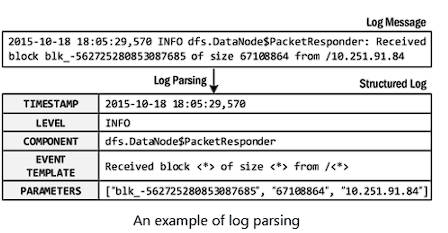

In [13]:
import pandas as pd
import re
import os

# Load span data
span_data_path = '/kaggle/input/deeptralogdate/TraceLogData/TraceLogData/F08/F08-02/ERROR_SpanData2021-07-30_10-13-04.csv'
span_df = pd.read_csv(span_data_path)

In [14]:
span_df.head( )

,StartTime,EndTime,URL,SpanType,Service,SpanId,TraceId,Peer,ParentSpan,Component,IsError
0,1627610136172,1627610136231,{POST}/api/v1/travelservice/trips/left,Entry,ts-travel-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-travel-service,-1,SpringMVC,False
1,1627610136175,1627610136179,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,Exit,ts-travel-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-ticketinfo-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,SpringRestTemplate,True
2,1627610136176,1627610136178,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,Entry,ts-ticketinfo-service,7f8a36aa96f7411d9294ed123155dde4.58.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-ticketinfo-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,Tomcat,True
3,1627610136180,1627610136184,/api/v1/ticketinfoservice/ticketinfo/Su Zhou,Exit,ts-travel-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-ticketinfo-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,SpringRestTemplate,True
4,1627610136180,1627610136182,/api/v1/ticketinfoservice/ticketinfo/Su%20Zhou,Entry,ts-ticketinfo-service,7f8a36aa96f7411d9294ed123155dde4.67.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-ticketinfo-service,89b560abeadc441fbecc8e595417ef12.60.1627610136...,Tomcat,True


In [15]:
span_df['IsError'].value_counts()

IsError
False    4250
True     1000
Name: count, dtype: int64

In [16]:
span_df['SpanId'][0]

'89b560abeadc441fbecc8e595417ef12.60.16276101361720022.0'

In [17]:
span_df['TraceId'][0]

'89b560abeadc441fbecc8e595417ef12.60.16276101361720023'

modify the 3d part of span id


In [18]:
def modify_span_id(span_id):
    parts = span_id.split('.')
    modified_span_id = '.'.join(parts[:3]) 
    return modified_span_id

#example = span_data['SpanId'][40]
#print(modify_span_id(example))
span_df['SpanId'] = span_df['SpanId'].apply(modify_span_id)
span_df['ParentSpan'] = span_df['ParentSpan'].apply(modify_span_id)

In [19]:
span_df['SpanId'][0]


'89b560abeadc441fbecc8e595417ef12.60.16276101361720022'

In [20]:
# span_df['StartTime'] = pd.to_datetime(span_df['StartTime'], unit='ms')
# span_df['EndTime'] = pd.to_datetime(span_df['EndTime'], unit='ms')

In [21]:
import re

def determine_event_type(url):
    if re.search(r'\{(GET|POST)\}/api/', url) or url.startswith('/api/'):
        return 'Client/Server span'
    else:
        return 'Producer/Consumer span'

span_df['event_type'] = span_df['URL'].apply(determine_event_type)

def create_span_events(span_data):
    span_events = []

    for index, row in span_data.iterrows():
        if 'Client/Server' in row['event_type']:
            span_events.append({
                'Timestamp': row['StartTime'],
                'event_type': 'Server Request',
                'operation_name': row['URL'],
                'SpanId': row['SpanId'],
                'TraceId': row['TraceId'],
                'Service': row['Service'],
                'Peer': row['Peer'],
                'Component': row['Component'],
                'IsError': row['IsError'],
                'ParentSpan':row['ParentSpan']
            })
            span_events.append({
                'Timestamp': row['EndTime'],
                'event_type': 'Server Response',
                'operation_name': row['URL'],
                'SpanId': row['SpanId'],
                'TraceId': row['TraceId'],
                'Service': row['Service'],
                'Peer': row['Peer'],
                'Component': row['Component'],
                'IsError': row['IsError'],
                'ParentSpan':row['ParentSpan']
            })
            
            if row['ParentSpan'] != '-1':
                span_events.append({
                    'Timestamp': row['StartTime'],
                    'event_type': 'Client Request',
                    'operation_name': row['URL'],
                    'SpanId': row['ParentSpan'],
                    'TraceId': row['TraceId'],
                    'Service': row['Service'],
                    'Peer': row['Peer'],
                    'Component': row['Component'],
                    'IsError': row['IsError'],
                    'ParentSpan':row['ParentSpan']
                })
                span_events.append({
                    'Timestamp': row['EndTime'],
                    'event_type': 'Client Response',
                    'operation_name': row['URL'],
                    'SpanId': row['ParentSpan'],
                    'TraceId': row['TraceId'],
                    'Service': row['Service'],
                    'Peer': row['Peer'],
                    'Component': row['Component'],
                    'IsError': row['IsError'],
                    'ParentSpan':row['ParentSpan']
                })
                
        elif 'Producer/Consumer' in row['event_type']:
            span_events.append({
                'Timestamp': row['StartTime'],
                'event_type': 'Consumer',
                'operation_name': row['URL'],
                'SpanId': row['SpanId'],
                'TraceId': row['TraceId'],
                'Service': row['Service'],
                'Peer': row['Peer'],
                'Component': row['Component'],
                'IsError': row['IsError'],
                'ParentSpan':row['ParentSpan']
            })
            span_events.append({
                'Timestamp': row['EndTime'],
                'event_type': 'Producer',
                'operation_name': row['URL'],
                'SpanId': row['ParentSpan'],
                'TraceId': row['TraceId'],
                'Service': row['Service'],
                'Peer': row['Peer'],
                'Component': row['Component'],
                'IsError': row['IsError'],
                'ParentSpan':row['ParentSpan']
            })

    span_events_df = pd.DataFrame(span_events)
    return span_events_df

span_events_df = create_span_events(span_df)

span_events_df.head()


,Timestamp,event_type,operation_name,SpanId,TraceId,Service,Peer,Component,IsError,ParentSpan
0,1627610136172,Server Request,{POST}/api/v1/travelservice/trips/left,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-travel-service,ts-travel-service,SpringMVC,False,-1
1,1627610136231,Server Response,{POST}/api/v1/travelservice/trips/left,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-travel-service,ts-travel-service,SpringMVC,False,-1
2,1627610136175,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.60.1627610136...
3,1627610136179,Server Response,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.60.1627610136...
4,1627610136175,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.60.1627610136...,89b560abeadc441fbecc8e595417ef12.60.1627610136...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.60.1627610136...


In [22]:
span_events_df['event_type'].value_counts()

event_type
Server Request     3750
Server Response    3750
Client Request     3500
Client Response    3500
Consumer           1500
Producer           1500
Name: count, dtype: int64

In [23]:
# Trier par timestamp si nécessaire
span_events_df.sort_values(by='Timestamp', inplace=True)

In [24]:
span_events_df.head()

,Timestamp,event_type,operation_name,SpanId,TraceId,Service,Peer,Component,IsError,ParentSpan
5460,1627609915001,Server Request,{POST}/api/v1/travelservice/trips/left,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-travel-service,SpringMVC,False,-1
5462,1627609915728,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...
5464,1627609915728,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...
5466,1627609915819,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,ts-ticketinfo-service,Tomcat,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...
5468,1627609915819,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,ts-ticketinfo-service,Tomcat,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...


In [25]:
span_events_df['SpanId'][0]

'89b560abeadc441fbecc8e595417ef12.60.16276101361720022'

In [26]:
span_events_df['TraceId'][0]

'89b560abeadc441fbecc8e595417ef12.60.16276101361720023'

In [27]:
span_events_df['Timestamp'] = pd.to_datetime(span_events_df['Timestamp'], unit='ms')


In [28]:
span_events_df.head()

,Timestamp,event_type,operation_name,SpanId,TraceId,Service,Peer,Component,IsError,ParentSpan
5460,2021-07-30 01:51:55.001,Server Request,{POST}/api/v1/travelservice/trips/left,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-travel-service,SpringMVC,False,-1
5462,2021-07-30 01:51:55.728,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...
5464,2021-07-30 01:51:55.728,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...
5466,2021-07-30 01:51:55.819,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,ts-ticketinfo-service,Tomcat,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...
5468,2021-07-30 01:51:55.819,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,ts-ticketinfo-service,Tomcat,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...


In [29]:
span_events_df['EventTemplate']=span_events_df['event_type']+' '+span_events_df['operation_name']

 **Combine Log and Span Events**

In [30]:
df_log= df_structured

In [31]:
df_log.head()

,LineId,Date,Time,SW_CTX,Thread,Level,Logger,Content,EventId,EventTemplate,ParameterList,TraceId,SpanId,Service,Timestamp,EventType,Operation
0,1,2021-07-30,09:51:59.820,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,Route is: Route{id='f3d4d4ef-693b-4456-8eed-59...,adf99278,Route is: Route{id='f3d4d4ef-693b-<*>-8eed-59c...,"['4456', '0', '50']",89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.820,Log Event,Route is: Route{id='f3d4d4ef-693b-<*>-8eed-59c...
1,2,2021-07-30,09:51:59.726,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,"Routes Response is : Response(status=1, msg=Su...",d85fb251,"Routes Response is : Response(status=<*>, msg=...","['1', 'data={id=f3d4d4ef-693b-4456-8eed-59c0d7...",89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.726,Log Event,"Routes Response is : Response(status=<*>, msg=..."
2,3,2021-07-30,09:51:59.721,"[SW_CTX:[ts-route-service,210e1b53d2204b648c90...",[http-nio-11178-exec-3],INFO,route.controller.RouteController,"Query route by id, RouteId: f3d4d4ef-693b-4456...",a222963e,"Query route by id, RouteId: <*>",['f3d4d4ef-693b-4456-8eed-59c0d717dd08'],85c69c7ce07f4f1d88a8758a38c60d76.62.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-route-service,2021-07-30 09:51:59.721,Log Event,"Query route by id, RouteId: <*>"
3,4,2021-07-30,09:51:59.718,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,[Travel Service][Get Route By Id] Route ID：f3d...,122e0d4b,[Travel Service][Get Route By Id] Route <*>,['ID：f3d4d4ef-693b-4456-8eed-59c0d717dd08'],89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.718,Log Event,[Travel Service][Get Route By Id] Route <*>
4,5,2021-07-30,09:51:59.717,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-9],INFO,travel.service.TravelServiceImpl,Route is: Route{id='084837bb-53c8-4438-87c8-03...,636c4d93,"Route is: <*> <*> shanghai], distances=[<*>, <...","[""Route{id='084837bb-53c8-4438-87c8-0321a4d099...",89b560abeadc441fbecc8e595417ef12.66.1627609919...,89b560abeadc441fbecc8e595417ef12.66.1627609919...,ts-travel-service,2021-07-30 09:51:59.717,Log Event,"Route is: <*> <*> shanghai], distances=[<*>, <..."


In [32]:
df_log['Level'].value_counts()

Level
INFO     5250
ERROR     500
Name: count, dtype: int64

In [33]:
df_log['ParentSpan']=df_log['SpanId']

In [34]:
df_log["IsError"] = df_log["Level"].apply(lambda x: True if x in ["ERROR", "WARN"] else False)


In [35]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5750 entries, 0 to 5749
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   LineId         5750 non-null   int64         
 1   Date           5750 non-null   object        
 2   Time           5750 non-null   object        
 3   SW_CTX         5750 non-null   object        
 4   Thread         5750 non-null   object        
 5   Level          5750 non-null   object        
 6   Logger         5750 non-null   object        
 7   Content        5750 non-null   object        
 8   EventId        5750 non-null   object        
 9   EventTemplate  5750 non-null   object        
 10  ParameterList  5750 non-null   object        
 11  TraceId        5750 non-null   object        
 12  SpanId         5750 non-null   object        
 13  Service        5750 non-null   object        
 14  Timestamp      5750 non-null   datetime64[ns]
 15  EventType      5750 n

In [36]:
span_events_df.head()

,Timestamp,event_type,operation_name,SpanId,TraceId,Service,Peer,Component,IsError,ParentSpan,EventTemplate
5460,2021-07-30 01:51:55.001,Server Request,{POST}/api/v1/travelservice/trips/left,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-travel-service,SpringMVC,False,-1,Server Request {POST}/api/v1/travelservice/tri...
5462,2021-07-30 01:51:55.728,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...,Server Request /api/v1/ticketinfoservice/ticke...
5464,2021-07-30 01:51:55.728,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,ts-ticketinfo-service,SpringRestTemplate,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...,Client Request /api/v1/ticketinfoservice/ticke...
5466,2021-07-30 01:51:55.819,Server Request,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,ts-ticketinfo-service,Tomcat,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...,Server Request /api/v1/ticketinfoservice/ticke...
5468,2021-07-30 01:51:55.819,Client Request,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,ts-ticketinfo-service,Tomcat,True,89b560abeadc441fbecc8e595417ef12.59.1627609915...,Client Request /api/v1/ticketinfoservice/ticke...


In [37]:
span_events_df['event_type'].value_counts()

event_type
Server Request     3750
Server Response    3750
Client Request     3500
Client Response    3500
Consumer           1500
Producer           1500
Name: count, dtype: int64

In [38]:
span_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17500 entries, 5460 to 1121
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       17500 non-null  datetime64[ns]
 1   event_type      17500 non-null  object        
 2   operation_name  17500 non-null  object        
 3   SpanId          17500 non-null  object        
 4   TraceId         17500 non-null  object        
 5   Service         17500 non-null  object        
 6   Peer            17500 non-null  object        
 7   Component       17500 non-null  object        
 8   IsError         17500 non-null  bool          
 9   ParentSpan      17500 non-null  object        
 10  EventTemplate   17500 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(9)
memory usage: 2.0+ MB


In [39]:
df_log['Timestamp'] [0]

Timestamp('2021-07-30 09:51:59.820000')

In [40]:
span_events_df['Timestamp'][0]

Timestamp('2021-07-30 01:55:36.172000')

In [41]:
df_log = df_log.sort_values(by=['Timestamp'])
span_events_df = span_events_df.sort_values(by=['Timestamp'])


In [42]:
df_log.head().head()

,LineId,Date,Time,SW_CTX,Thread,Level,Logger,Content,EventId,EventTemplate,ParameterList,TraceId,SpanId,Service,Timestamp,EventType,Operation,ParentSpan,IsError
160,161,2021-07-30,09:51:55.726,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-2],INFO,travel.controller.TravelController,Query TripResponse,bc741cff,Query TripResponse,[],89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,2021-07-30 09:51:55.726,Log Event,Query TripResponse,89b560abeadc441fbecc8e595417ef12.59.1627609915...,False
159,160,2021-07-30,09:51:55.829,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-2],ERROR,travel.service.TravelServiceImpl,request for ticket info service namelist denye...,97d2783b,request for ticket info service namelist denye...,['403'],89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,2021-07-30 09:51:55.829,Log Event,request for ticket info service namelist denye...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True
158,159,2021-07-30,09:51:55.838,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-2],ERROR,travel.service.TravelServiceImpl,request for ticket info service namelist denye...,97d2783b,request for ticket info service namelist denye...,['403'],89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,2021-07-30 09:51:55.838,Log Event,request for ticket info service namelist denye...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True
157,158,2021-07-30,09:51:55.846,"[SW_CTX:[ts-travel-service,41e74833f30b491ba03...",[http-nio-12346-exec-2],INFO,travel.service.TravelServiceImpl,[Travel Service][Get Route By Id] Route ID：927...,122e0d4b,[Travel Service][Get Route By Id] Route <*>,['ID：92708982-77af-4318-be25-57ccb0ff69ad'],89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,2021-07-30 09:51:55.846,Log Event,[Travel Service][Get Route By Id] Route <*>,89b560abeadc441fbecc8e595417ef12.59.1627609915...,False
156,157,2021-07-30,09:51:55.856,"[SW_CTX:[ts-route-service,210e1b53d2204b648c90...",[http-nio-11178-exec-9],INFO,route.controller.RouteController,"Query route by id, RouteId: 92708982-77af-4318...",a222963e,"Query route by id, RouteId: <*>",['92708982-77af-4318-be25-57ccb0ff69ad'],85c69c7ce07f4f1d88a8758a38c60d76.68.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-route-service,2021-07-30 09:51:55.856,Log Event,"Query route by id, RouteId: <*>",89b560abeadc441fbecc8e595417ef12.59.1627609915...,False


In [43]:
df_log_selected = df_log[[
    'Timestamp', 'TraceId', 'SpanId', 'Service',
    'EventType', 'EventTemplate', 'Operation','ParentSpan' ,'IsError'
]]

# Harmoniser span_events_df AVANT concat
span_events_df_renamed = span_events_df.rename(columns={
    'event_type': 'EventType',
    'operation_name' :'Operation' 
})

span_events_selected = span_events_df_renamed[[
    'Timestamp', 'TraceId', 'SpanId', 'Service',
    'EventType','EventTemplate', 'Operation','ParentSpan' ,'IsError'
]]

# Fusion propre
combined_df = pd.concat([df_log_selected, span_events_selected], ignore_index=True)
combined_df.sort_values(by='Timestamp', inplace=True)
combined_df.reset_index(drop=True, inplace=True)


In [44]:
combined_df.head()

,Timestamp,TraceId,SpanId,Service,EventType,EventTemplate,Operation,ParentSpan,IsError
0,2021-07-30 01:51:55.001,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request {POST}/api/v1/travelservice/tri...,{POST}/api/v1/travelservice/trips/left,-1,False
1,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True
2,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True
3,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,ts-ticketinfo-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True
4,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True


In [45]:
combined_df['EventType'].value_counts()


EventType
Log Event          5750
Server Response    3750
Server Request     3750
Client Request     3500
Client Response    3500
Consumer           1500
Producer           1500
Name: count, dtype: int64

# Event Embedding

In [46]:
from gensim.parsing.preprocessing import remove_stopwords
import gensim.downloader as api
import string
import re
import math

In [47]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
def preprocess_text(text):
    # 1. Minuscule
    text = text.lower()
    
    # 2. Remplacer les séparateurs non verbaux par espace
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # # 3. Séparer les mots composés camel case (facultatif si tu veux affiner)
    # text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # 4. Séparer les chiffres collés aux lettres (ex: tripid123 → tripid 123)
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)

    # 5. Tokenization
    words = text.split()

    # 6. Supprimer les stop words
    words = [word for word in words if word not in stop_words]

    # 7. Reformer la phrase
    return ' '.join(words)


In [49]:
combined_df['ProcessedText'] = combined_df['EventTemplate'].apply(preprocess_text)


In [50]:
combined_df.head()

,Timestamp,TraceId,SpanId,Service,EventType,EventTemplate,Operation,ParentSpan,IsError,ProcessedText
0,2021-07-30 01:51:55.001,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request {POST}/api/v1/travelservice/tri...,{POST}/api/v1/travelservice/trips/left,-1,False,server request post api v 1 travelservice trip...
1,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,server request api v 1 ticketinfoservice ticke...
2,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,client request api v 1 ticketinfoservice ticke...
3,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,ts-ticketinfo-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,server request api v 1 ticketinfoservice ticke...
4,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,client request api v 1 ticketinfoservice ticke...


**step 2**

In [51]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-300") 


In [52]:
def word_embedding(word):
    try:
        return word_vectors.get_vector(word)
    except KeyError:
        return np.zeros(300)


In [53]:
log_events = combined_df[combined_df['EventType'] == 'Log Event'].copy()
span_events = combined_df[combined_df['EventType'] != 'Log Event'].copy()


In [54]:
def get_weighted_sentence_embedding(text, tfidf_vectorizer, tfidf_matrix, row_index):
    words = text.split()
    embedding = np.zeros(300)
    count = 0

    for word in words:
        if word in tfidf_vectorizer.vocabulary_:
            tfidf_score = tfidf_matrix[row_index, tfidf_vectorizer.vocabulary_[word]]
            vector = word_embedding(word)
            embedding += tfidf_score * vector
            count += 1

    return embedding / count if count > 0 else embedding

In [55]:
combined_df = combined_df[combined_df['ProcessedText'] != ''].reset_index(drop=True)

In [56]:
# TF-IDF Fit
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_df['ProcessedText'])

In [57]:
# 💡 Generate embeddings for all events
print("Generating embeddings...")
event_embeddings = np.array([
    get_weighted_sentence_embedding(text, tfidf_vectorizer, tfidf_matrix, idx)
    for idx, text in enumerate(combined_df['ProcessedText'])
])
print("Embeddings generated.")

Generating embeddings...
Embeddings generated.


In [58]:
embedding_df = pd.DataFrame(event_embeddings, columns=[f'emb_{i}' for i in range(300)])
combined_df_with_embeddings = pd.concat([combined_df.reset_index(drop=True), embedding_df], axis=1)

In [59]:
import numpy as np

# Step 1: Identify the embedding columns
embedding_columns = [f'emb_{i}' for i in range(300)]

# Step 2: Combine them into a single list for each row
combined_df_with_embeddings['embedding'] = combined_df_with_embeddings[embedding_columns].values.tolist()


In [60]:
combined_df_with_embeddings.drop(columns=embedding_columns, inplace=True)


In [61]:
combined_df_with_embeddings.head()

,Timestamp,TraceId,SpanId,Service,EventType,EventTemplate,Operation,ParentSpan,IsError,ProcessedText,embedding
0,2021-07-30 01:51:55.001,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request {POST}/api/v1/travelservice/tri...,{POST}/api/v1/travelservice/trips/left,-1,False,server request post api v 1 travelservice trip...,"[-0.08523908496967383, 0.005535611217575414, 0..."
1,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,server request api v 1 ticketinfoservice ticke...,"[-0.1064139913235392, -0.04877018555998802, 0...."
2,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,client request api v 1 ticketinfoservice ticke...,"[-0.09360785463026591, -0.06693696017776217, 0..."
3,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,ts-ticketinfo-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,server request api v 1 ticketinfoservice ticke...,"[-0.10631798580288887, -0.029515796341001987, ..."
4,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,client request api v 1 ticketinfoservice ticke...,"[-0.09624521248042583, -0.04380502225831151, 0..."


# Graph construction

In [65]:
combined_df_with_embeddings.head()

,Timestamp,TraceId,SpanId,Service,EventType,EventTemplate,Operation,ParentSpan,IsError,ProcessedText,embedding
0,2021-07-30 01:51:55.001,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request {POST}/api/v1/travelservice/tri...,{POST}/api/v1/travelservice/trips/left,-1,False,server request post api v 1 travelservice trip...,"[-0.08523908496967383, 0.005535611217575414, 0..."
1,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,server request api v 1 ticketinfoservice ticke...,"[-0.1064139913235392, -0.04877018555998802, 0...."
2,2021-07-30 01:51:55.728,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-travel-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,client request api v 1 ticketinfoservice ticke...,"[-0.09360785463026591, -0.06693696017776217, 0..."
3,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,7f8a36aa96f7411d9294ed123155dde4.63.1627609915...,ts-ticketinfo-service,Server Request,Server Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,server request api v 1 ticketinfoservice ticke...,"[-0.10631798580288887, -0.029515796341001987, ..."
4,2021-07-30 01:51:55.819,89b560abeadc441fbecc8e595417ef12.59.1627609915...,89b560abeadc441fbecc8e595417ef12.59.1627609915...,ts-ticketinfo-service,Client Request,Client Request /api/v1/ticketinfoservice/ticke...,/api/v1/ticketinfoservice/ticketinfo/Shang%20Hai,89b560abeadc441fbecc8e595417ef12.59.1627609915...,True,client request api v 1 ticketinfoservice ticke...,"[-0.09624521248042583, -0.04380502225831151, 0..."


In [66]:
combined_df_with_embeddings['EventType'].value_counts()

EventType
Log Event          5750
Server Response    3750
Server Request     3750
Client Request     3500
Client Response    3500
Consumer           1500
Producer           1500
Name: count, dtype: int64

**step  1**

In [67]:
import pandas as pd
import networkx as nx

# Exemple : filtrer une seule trace pour commencer
trace_id = combined_df_with_embeddings['TraceId'].iloc[0]
trace_df = combined_df_with_embeddings[combined_df_with_embeddings['TraceId'] == trace_id]

# Création du graphe TEG
G = nx.DiGraph()

# Ajouter tous les événements comme nœuds
for idx, row in trace_df.iterrows():
    G.add_node(idx, 
               Timestamp=row['Timestamp'], 
               SpanId=row['SpanId'], 
               EventType=row['EventType'], 
               embedding=row['embedding'])

# Connexion séquentielle des événements par SpanId (relation "sequence")
for span_id, group in trace_df.groupby('SpanId'):
    group_sorted = group.sort_values(by='Timestamp')
    indices = group_sorted.index.to_list()
    
    for i in range(len(indices) - 1):
        src = indices[i]
        dst = indices[i + 1]
        G.add_edge(src, dst, relationship='sequence')

print(f"Graphe TEG construit pour TraceId = {trace_id} :")
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")


Graphe TEG construit pour TraceId = 89b560abeadc441fbecc8e595417ef12.59.16276099150010001 :
Nombre de nœuds : 70
Nombre d'arêtes : 62


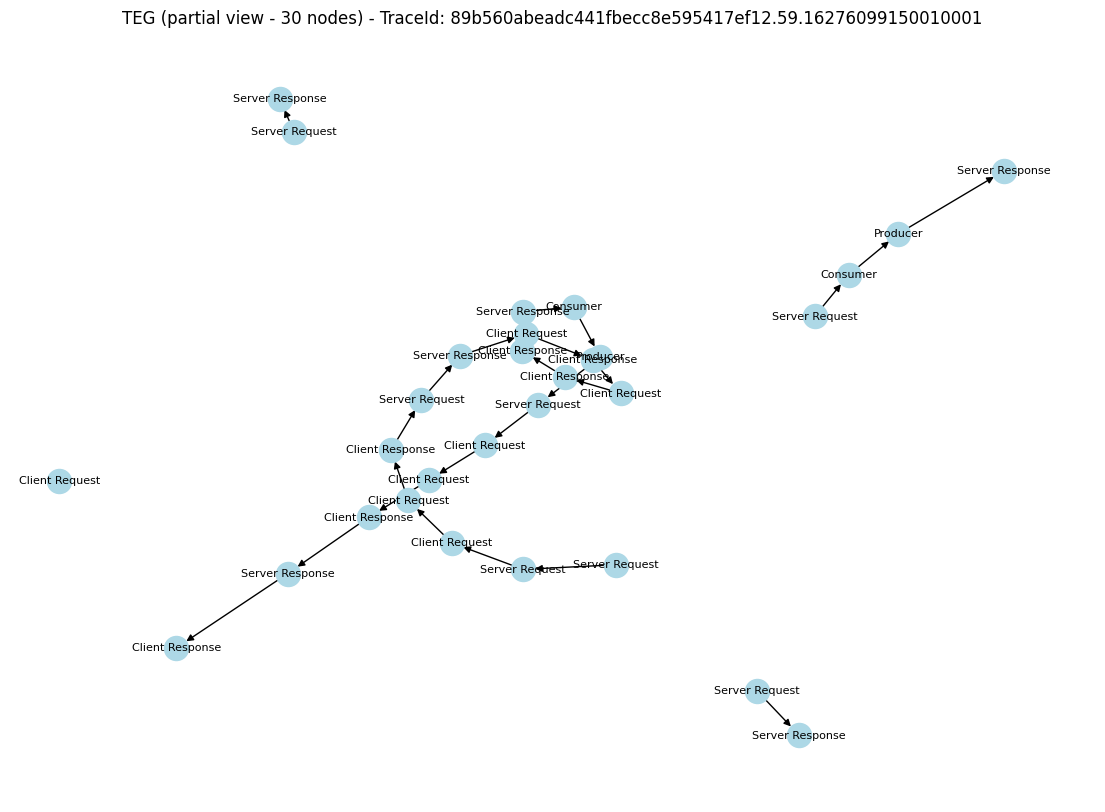

In [68]:
# Sélection de 30 nœuds au hasard ou les premiers
import matplotlib.pyplot as plt 

sample_nodes = list(G.nodes)[:30]  # ou random.sample(list(G.nodes), 30)

# Extraire le sous-graphe
subG = G.subgraph(sample_nodes)

# Affichage du sous-graphe
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(subG, seed=42)

# Noeuds
nx.draw_networkx_nodes(subG, pos, node_size=300, node_color='lightblue')

# Arêtes
nx.draw_networkx_edges(subG, pos, arrows=True)

# Labels
labels = {node: subG.nodes[node]['EventType'] for node in subG.nodes}
nx.draw_networkx_labels(subG, pos, labels, font_size=8)

plt.title(f"TEG (partial view - {len(subG)} nodes) - TraceId: {trace_id}")
plt.axis('off')
plt.show()


In [69]:
# Exemple : afficher tous les événements d’un span, triés par Timestamp
span_id = trace_df['SpanId'].unique()[0]
span_events = trace_df[trace_df['SpanId'] == span_id].sort_values(by='Timestamp')

print(span_events[['Timestamp', 'EventType']])


                 Timestamp        EventType
0  2021-07-30 01:51:55.001   Server Request
1  2021-07-30 01:51:55.728   Server Request
2  2021-07-30 01:51:55.728   Client Request
4  2021-07-30 01:51:55.819   Client Request
6  2021-07-30 01:51:55.826  Client Response
7  2021-07-30 01:51:55.829   Server Request
8  2021-07-30 01:51:55.829  Server Response
9  2021-07-30 01:51:55.829   Client Request
10 2021-07-30 01:51:55.829  Client Response
12 2021-07-30 01:51:55.831   Client Request
13 2021-07-30 01:51:55.837  Client Response
15 2021-07-30 01:51:55.838  Client Response
16 2021-07-30 01:51:55.838  Server Response
17 2021-07-30 01:51:55.839         Consumer
18 2021-07-30 01:51:55.842         Producer
19 2021-07-30 01:51:55.847   Server Request
20 2021-07-30 01:51:55.847   Client Request
22 2021-07-30 01:51:55.851   Client Request
25 2021-07-30 01:51:55.864  Client Response
27 2021-07-30 01:51:55.917  Server Response
28 2021-07-30 01:51:55.917  Client Response
30 2021-07-30 01:51:55.928   Ser

**all steps for an exemple of trace**

In [70]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Sélection d'une seule trace
trace_id = combined_df_with_embeddings['TraceId'].iloc[0]
trace_df = combined_df_with_embeddings[combined_df_with_embeddings['TraceId'] == trace_id]

# 2. Création du graphe orienté
G = nx.DiGraph()

# 3. Ajouter tous les événements comme nœuds
for idx, row in trace_df.iterrows():
    G.add_node(idx,
               Timestamp=row['Timestamp'],
               SpanId=row['SpanId'],
               EventType=row['EventType'],
               embedding=row['embedding'])

# 4. Ajouter les arêtes de type "sequence" (intra-span)
for span_id, group in trace_df.groupby('SpanId'):
    group_sorted = group.sort_values(by='Timestamp')
    indices = group_sorted.index.to_list()
    
    for i in range(len(indices) - 1):
        G.add_edge(indices[i], indices[i + 1], relationship='sequence')

# 5. Ajouter les arêtes inter-span (étape 3 : sync_request, sync_response, async_request)
for span_id, span_df in trace_df.groupby("SpanId"):
    parent_span_id = span_df["ParentSpan"].iloc[0]
    
    if parent_span_id == -1 or parent_span_id not in trace_df["SpanId"].values:
        continue

    parent_df = trace_df[trace_df["SpanId"] == parent_span_id]

    # SYNC REQUEST
    parent_client_req = parent_df[parent_df["EventType"] == "Client Request"]
    child_server_req = span_df[span_df["EventType"] == "Server Request"]
    if not parent_client_req.empty and not child_server_req.empty:
        G.add_edge(parent_client_req.index[0],
                   child_server_req.index[0],
                   relationship="sync_request")

    # SYNC RESPONSE
    child_server_resp = span_df[span_df["EventType"] == "Server Response"]
    parent_client_resp = parent_df[parent_df["EventType"] == "Client Response"]
    if not child_server_resp.empty and not parent_client_resp.empty:
        G.add_edge(child_server_resp.index[0],
                   parent_client_resp.index[0],
                   relationship="sync_response")

    # ASYNC REQUEST
    parent_producer = parent_df[parent_df["EventType"] == "Producer"]
    child_consumer = span_df[span_df["EventType"] == "Consumer"]
    if not parent_producer.empty and not child_consumer.empty:
        G.add_edge(parent_producer.index[0],
                   child_consumer.index[0],
                   relationship="async_request")

# 6. Affichage
print(f"Graphe TEG construit pour TraceId = {trace_id} :")
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")


Graphe TEG construit pour TraceId = 89b560abeadc441fbecc8e595417ef12.59.16276099150010001 :
Nombre de nœuds : 70
Nombre d'arêtes : 81


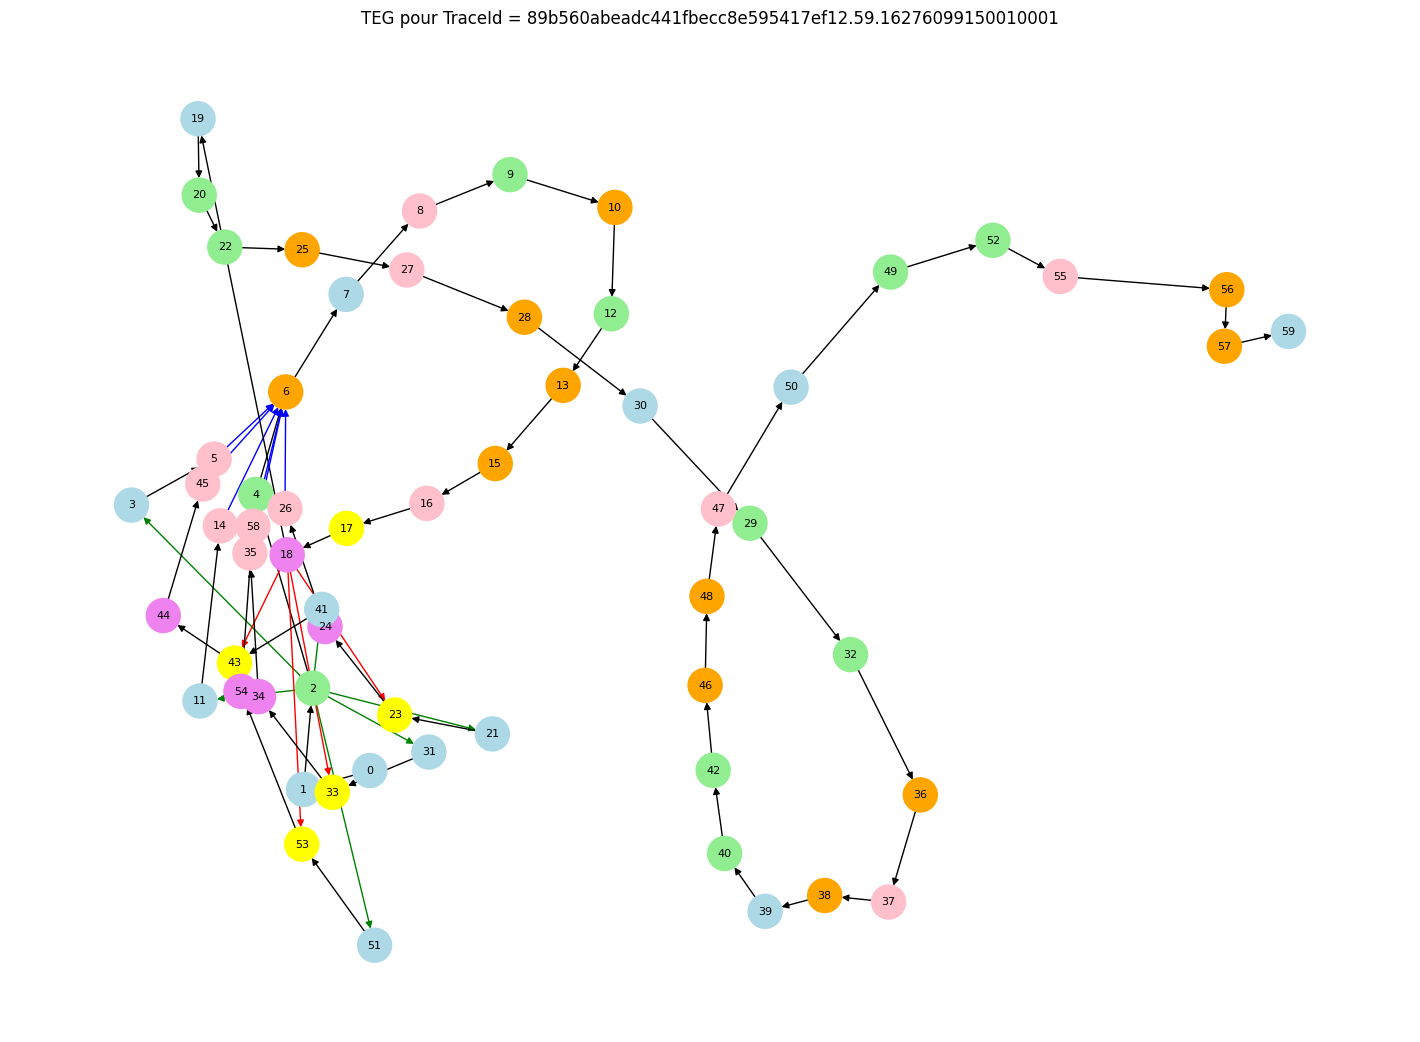

In [71]:
# 7. Prendre un sous-graphe pour l'affichage 
sub_nodes = list(G.nodes)[:60]
subG = G.subgraph(sub_nodes)

# Positions des nœuds
pos = nx.spring_layout(subG, seed=42)

# Couleurs des nœuds selon le type d’événement
node_colors = []
for node in subG.nodes:
    event_type = G.nodes[node]['EventType']
    if event_type == "Client Request":
        node_colors.append("lightgreen")
    elif event_type == "Server Request":
        node_colors.append("lightblue")
    elif event_type == "Client Response":
        node_colors.append("orange")
    elif event_type == "Server Response":
        node_colors.append("pink")
    elif event_type == "Producer":
        node_colors.append("violet")
    elif event_type == "Consumer":
        node_colors.append("yellow")
    else:
        node_colors.append("gray")

# Couleurs des arêtes selon la relation
edge_colors = []
for _, _, data in subG.edges(data=True):
    if data['relationship'] == 'sequence':
        edge_colors.append('black')
    elif data['relationship'] == 'sync_request':
        edge_colors.append('green')
    elif data['relationship'] == 'sync_response':
        edge_colors.append('blue')
    elif data['relationship'] == 'async_request':
        edge_colors.append('red')
    else:
        edge_colors.append('gray')

# Affichage
plt.figure(figsize=(14, 10))
nx.draw(subG, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        arrows=True, node_size=600, font_size=8)
plt.title(f"TEG pour TraceId = {trace_id}")
plt.show()


In [ ]:
# #fonction general : 
# import networkx as nx

# def build_teg_from_trace(trace_df):
#     """
#     Construit un TEG (Trace Event Graph) pour un sous-ensemble de combined_df correspondant à un seul TraceId.
    
#     :param trace_df: DataFrame contenant les événements d'une seule trace (filtré par TraceId)
#     :return: Graphe orienté NetworkX avec les types d’arêtes : sequence, sync_request, sync_response, async_request
#     """
#     G = nx.DiGraph()

#     # 1. Ajouter les nœuds
#     for idx, row in trace_df.iterrows():
#         G.add_node(idx,
#                    Timestamp=row['Timestamp'],
#                    SpanId=row['SpanId'],
#                    EventType=row['EventType'],
#                    embedding=row['embedding'])

#     # 2. Ajouter les arêtes intra-span (sequence)
#     for span_id, group in trace_df.groupby('SpanId'):
#         group_sorted = group.sort_values(by='Timestamp')
#         indices = group_sorted.index.to_list()
#         for i in range(len(indices) - 1):
#             G.add_edge(indices[i], indices[i + 1], relationship='sequence')

#     # 3. Ajouter les arêtes inter-span (synchronous/asynchronous relations)
#     for span_id, span_df in trace_df.groupby("SpanId"):
#         parent_span_id = span_df["ParentSpan"].iloc[0]
#         if parent_span_id == -1 or parent_span_id not in trace_df["SpanId"].values:
#             continue

#         parent_df = trace_df[trace_df["SpanId"] == parent_span_id]

#         # SYNC REQUEST
#         parent_client_req = parent_df[parent_df["EventType"] == "Client Request"]
#         child_server_req = span_df[span_df["EventType"] == "Server Request"]
#         if not parent_client_req.empty and not child_server_req.empty:
#             G.add_edge(parent_client_req.index[0],
#                        child_server_req.index[0],
#                        relationship="sync_request")

#         # SYNC RESPONSE
#         child_server_resp = span_df[span_df["EventType"] == "Server Response"]
#         parent_client_resp = parent_df[parent_df["EventType"] == "Client Response"]
#         if not child_server_resp.empty and not parent_client_resp.empty:
#             G.add_edge(child_server_resp.index[0],
#                        parent_client_resp.index[0],
#                        relationship="sync_response")

#         # ASYNC REQUEST
#         parent_producer = parent_df[parent_df["EventType"] == "Producer"]
#         child_consumer = span_df[span_df["EventType"] == "Consumer"]
#         if not parent_producer.empty and not child_consumer.empty:
#             G.add_edge(parent_producer.index[0],
#                        child_consumer.index[0],
#                        relationship="async_request")

#     return G


# prepare graph data

In [ ]:
# # save_as_official_format.py

# import json
# import os
# import pandas as pd
# import networkx as nx
# from tqdm import tqdm

# def export_tegs_to_official_format(tegs_by_traceid, label_dict=None, out_dir="graph_data"):
#     os.makedirs(out_dir, exist_ok=True)

#     edge_type_map = {
#         "sequence": 0,
#         "sync_request": 1,
#         "sync_response": 2,
#         "async_request": 3
#     }

#     service_set = set()
#     url_temp_set = set()
#     url_type_list = []

#     for idx, (trace_id, G) in tqdm(enumerate(tegs_by_traceid.items()), total=len(tegs_by_traceid)):
#         node_mapping = {}
#         node_info = []
#         for i, node in enumerate(G.nodes()):
#             emb = G.nodes[node].get("embedding", [])
#             node_info.append(emb)
#             node_mapping[node] = i

#             # Collect service for id_service.csv
#             service = G.nodes[node].get("Service", None)
#             if service:
#                 service_set.add(service)

#             # Collect EventTemplate
#             temp = G.nodes[node].get("EventTemplate", "")
#             url_temp_set.add(temp)

#             # Optionally collect EventType for id_url+type.csv
#             etype = G.nodes[node].get("EventType", "")
#             if temp:
#                 url_type_list.append((temp, etype))

#         # Arêtes
#         edge_index = [[], []]
#         edge_attr = []
#         for src, dst, data in G.edges(data=True):
#             if src in node_mapping and dst in node_mapping:
#                 edge_index[0].append(node_mapping[src])
#                 edge_index[1].append(node_mapping[dst])
#                 edge_type = data.get("relationship", "sequence")
#                 edge_attr.append(edge_type_map.get(edge_type, 0))

#         trace_info = {
#             "edge_index": edge_index,
#             "edge_attr": edge_attr,
#             "node_info": node_info,
#             "trace_id": trace_id,
#             "trace_bool": True if (label_dict is None or label_dict.get(trace_id, 0) == 0) else False,
#             "error_trace_type": "normal" if (label_dict is None or label_dict.get(trace_id, 0) == 0) else "anomaly"
#         }

#         with open(os.path.join(out_dir, f"process{idx}.json"), "w") as f:
#             json.dump(trace_info, f)

#     # id_service.csv
#     service_list = sorted(service_set)
#     pd.DataFrame({"Service": service_list}).to_csv(os.path.join(out_dir, "id_service.csv"))

#     # id_url+temp.csv
#     temp_list = sorted(url_temp_set)
#     pd.DataFrame({"EventTemplate": temp_list}).to_csv(os.path.join(out_dir, "id_url+temp.csv"))

#     # id_url+type.csv
#     df_temp_type = pd.DataFrame(url_type_list, columns=["Content", "Type"]).drop_duplicates()
#     df_temp_type.insert(0, "Temp", range(len(df_temp_type)))
#     df_temp_type["Type"] = df_temp_type["Type"].astype("category").cat.codes
#     df_temp_type.to_csv(os.path.join(out_dir, "id_url+type.csv"), index=False)

#     print(f"\n✅ Export terminé : {len(tegs_by_traceid)} graphes sauvegardés dans '{out_dir}'.")



In [ ]:
# from save_as_official_format import export_tegs_to_official_format

# # tegs_by_traceid : dict { trace_id: networkx.DiGraph }
# # label_dict : { trace_id: 0/1 }, 0 = normal, 1 = anomalie (facultatif)

# export_tegs_to_official_format(tegs_by_traceid, label_dict=None, out_dir="graph_data")
